### Example notebook for WorkStation - OMICS correlation: gene to gene

This notebook demonstrates reading from API and performing analysis of OMICS data correlation.
- title: "OMICS correlation: gene to gene"
- author: "Margaret Paiva"
- date: "25/10/2021"
- output: R notebook

In [17]:
# Check your R version if packages are not compatible
R.version

In [2]:
suppressPackageStartupMessages(library(jsonlite))
suppressPackageStartupMessages(library(rjson))
suppressPackageStartupMessages(library(httr))
suppressPackageStartupMessages(library(dplyr))
suppressPackageStartupMessages(library(data.table))
suppressPackageStartupMessages(library(tidyr))
suppressPackageStartupMessages(library(tibble))
suppressPackageStartupMessages(library(ggplot2))

Request data from API if it is not done yet.

In [3]:
# Define the data to query from API
data  <- list("request_data_type" = "expression",
  "request_cancer_type" = list("all"),
  "request_genes" = c("ATM", "BRCA1", "BRCA2", "BRIP1", "CDK12", "FANCA", "HDAC2", "KRAS", 
                      "PALB2", "SRY", "TP53", "NOTCH1", "CCND1", "BARD1", "FBLN2", "CDKN1B", 
                      "RB1", "CHEK2", "APOBEC3B", "PALB2"),  # to define a list of genes here
  "request_dataset" = "PDX",
  "request_key" = "a3208f8f73654023bd0f267eb9d014bb",
  "request_client" = 99,
  "request_user" = 99,
  "request_mode" = 'true') 

In [9]:
# Request data from API - this may take some time
request  <-  POST(url = 'https://lumin-fast-api.championsoncology.com/workstation', 
                  body = data, encode = 'json')
request
# A successful request will give "Status: 200"

In [36]:
# This will save the data file as a .json file in your root directory
response <- content(request)
response

[1] "success, the file you may view your requested data in your root directory"

In [4]:
# Enter the file name of the .json file in your root directory below
lt  <-  fromJSON(file = "./data/requested_data---22-10-2021---16_01_19.json")

In [5]:
# Create a dataframe from the data
df  <- do.call(rbind, lapply(lt, rbind))
df  <- as.data.frame(df)
df$gene  <- as.character(df$gene)  # each column is a list - specify data type
df$log.tpm  <- as.numeric(df$log.tpm)
head(df, 2)
print(dim(df))

v1,gene_id,log.rsem.rpkm,log.tpm,z,fold,trans,model,sort_key,gene,model_name,tumor_type
16543076,ENSG00000012048,2.48625433850603,3.081518,-1.12382363797508,0.751459769651646,ENST00000351666:62.89% ENST00000354071:27.08%,CTG-2829,CTG-2829_Expression_1,BRCA1,CTG-2829,Breast
16544344,ENSG00000083093,4.77007909981351,5.353008,3.2876292952754,1.51710991376448,ENST00000566069:66.71% ENST00000568219:33.04%,CTG-2829,CTG-2829_Expression_1,PALB2,CTG-2829,Breast


[1] 20640    12


In [6]:
# Extract the expression values and pivot a table for genes
gene_tpm <- df %>% 
  dplyr::select(gene, log.tpm, model) %>% 
  na.omit() %>% 
  pivot_wider(names_from = gene, 
              values_from = log.tpm) %>% 
  column_to_rownames('model')
gene_tpm[1:5, 1:5]

,BRCA1,PALB2,CCND1,CDKN1B,KRAS
CTG-2829,3.081518,5.353008,6.612856,6.256398,3.587479
CTG-0437,3.618647,3.687081,4.885116,5.735280,5.146602
CTG-0093,3.602469,3.144759,6.614539,5.466478,5.730350
CTG-2535,3.690036,4.030954,3.899270,6.115044,3.533881
CTG-0664,4.185268,4.575462,4.908090,4.991020,4.077113


In [16]:
# Example to correlate two genes
rho <- cor(gene_tpm$BRCA1, gene_tpm$BRCA2)
rho

[1] 0.6244586

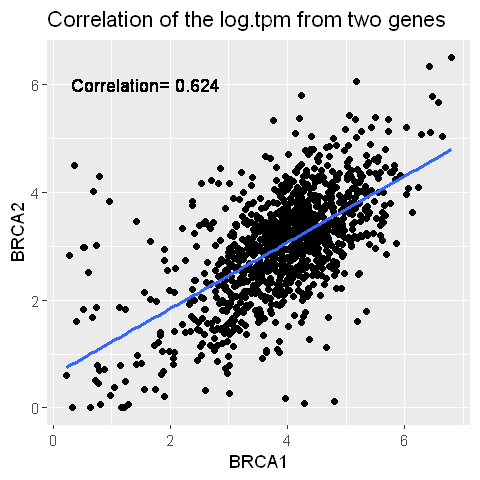

In [35]:
options(repr.plot.width = 4, repr.plot.height = 4)
ggplot(gene_tpm, mapping = aes(x = BRCA1, y = BRCA2))+
geom_point()+
geom_smooth(method = "lm", se = FALSE, formula = y ~ x)+
geom_text(x = 1.6, y = 6, label = paste("Correlation=", round(rho, 3), collapse=""))+
ggtitle("Correlation of the log.tpm from two genes")+
xlab("BRCA1")+
ylab("BRCA2")

In [25]:
cormat <- round(cor(gene_tpm), 1)
cormat[1:5, 1:5]

,BRCA1,PALB2,CCND1,CDKN1B,KRAS
BRCA1,1.0,0.6,0.0,0.3,0.3
PALB2,0.6,1.0,0.2,0.4,0.5
CCND1,0.0,0.2,1.0,0.1,0.2
CDKN1B,0.3,0.4,0.1,1.0,0.3
KRAS,0.3,0.5,0.2,0.3,1.0


In [26]:
get_lower_tri<-function(cormat){
    cormat[upper.tri(cormat)] <- NA
    return(cormat)}

In [27]:
lower_tri <- get_lower_tri(cormat)
lower_tri[1:5, 1:5]

,BRCA1,PALB2,CCND1,CDKN1B,KRAS
BRCA1,1.0,NA,NA,NA,NA
PALB2,0.6,1.0,NA,NA,NA
CCND1,0.0,0.2,1.0,NA,NA
CDKN1B,0.3,0.4,0.1,1.0,NA
KRAS,0.3,0.5,0.2,0.3,1


In [28]:
library(reshape2)

In [29]:
melted_cormat <- melt(lower_tri, na.rm = TRUE)

Need to fix
- negative values in the correlation matrix
- remove SRY, which produced NAN
- may put heatmap as a notebook "omics_annotated_correlation_map_R"

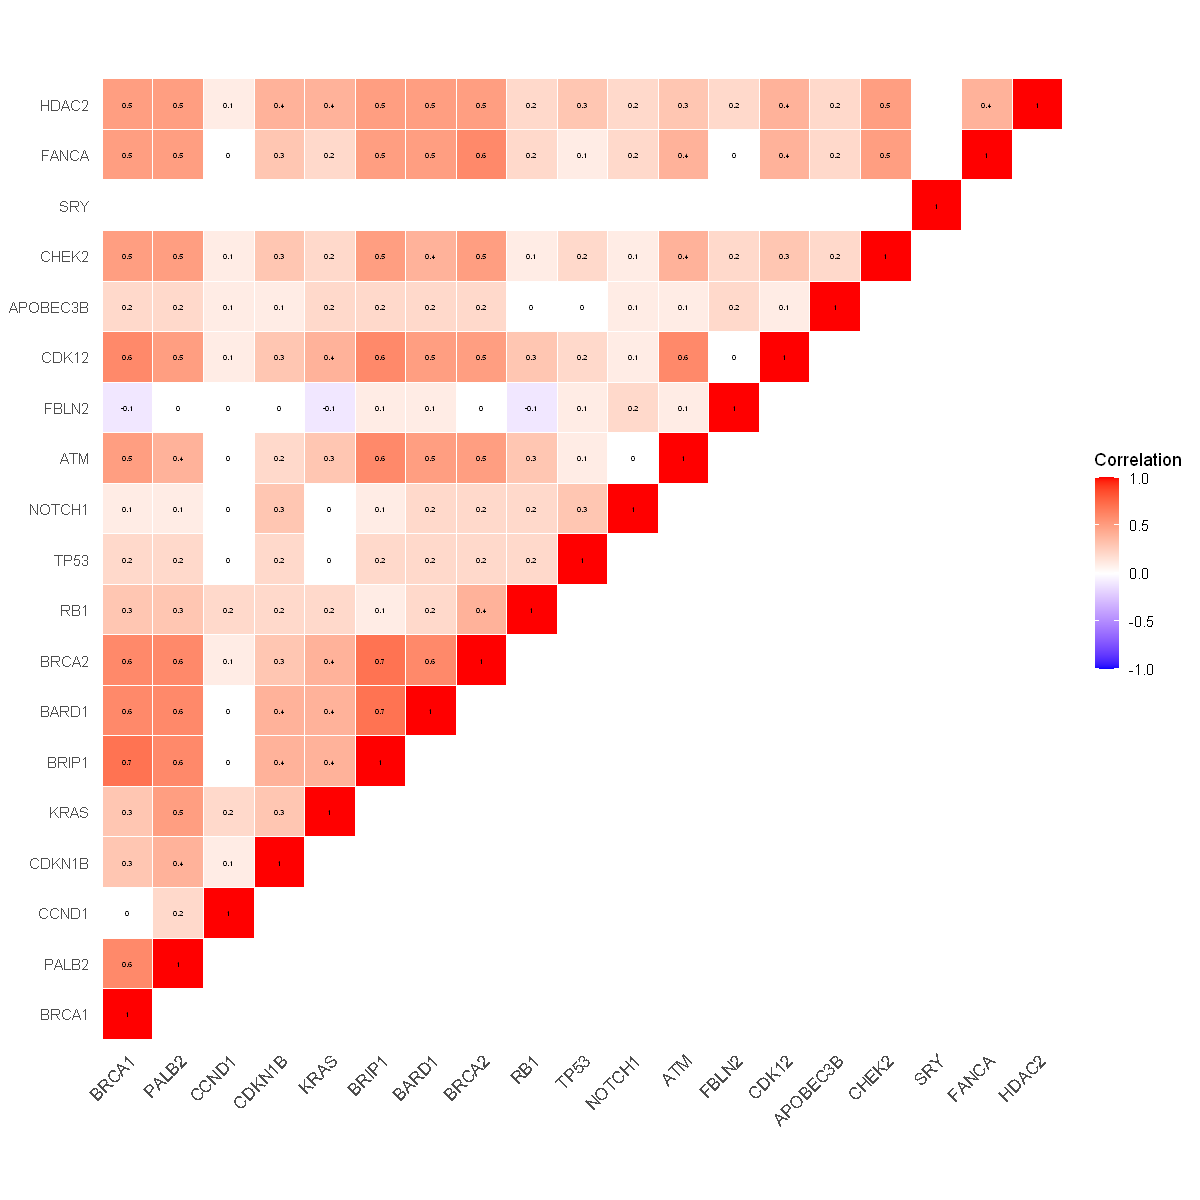

In [32]:
# Heatmap
options(repr.plot.width = 10, repr.plot.height = 10)
ggplot(data = melted_cormat, aes(Var2, Var1, fill = value))+
 geom_tile(color = "white")+
 scale_fill_gradient2(low = "blue", high = "red", mid = "white", 
   midpoint = 0, limit = c(-1,1), space = "Lab", 
   name="Correlation") +
  theme_minimal()+ 
 theme(axis.text.x = element_text(angle = 45, vjust = 1, 
    size = 10, hjust = 1))+
 coord_fixed()+
 geom_text(aes(Var2, Var1, label = value), color = "black", size = 1.5)+
 theme(
  axis.title.x = element_blank(),
  axis.title.y = element_blank(),
  panel.grid.major = element_blank(),
  panel.border = element_blank(),
  panel.background = element_blank(),
  axis.ticks = element_blank())+
  guides(fill = guide_colorbar(barwidth = 1, barheight = 8,
                title.position = "top", title.hjust = 0.5))